<a href="https://colab.research.google.com/github/emilybraunb/Bioinfo_2025/blob/main/Atividade_complementar_emily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Caso 2:
Paciente com suspeita de uma síndrome metabólica

Descrição: Paciente lactente bebê, sexo masculino, 6 meses, apresentada na consulta de pediatria geneticista devido a triagem neonatal alterada evidenciando níveis elevados de fenilalanina e atraso incipiente no desenvolvimento neuropsicomotor.

Procedimento: Painel genético específico para análise de variantes no gene PAH, realizado a partir de amostra de sangue.

Objetivo: Identificar variantes genéticas responsáveis pela fenilcetonúria (PKU), fornecendo base para diagnóstico precoce e orientações terapêuticas individualizadas para prevenção de complicações neurológicas.


 Não se esqueçam de fazer filtros e limpezas nas variantes, pois nem todas são verdadeiras. O laudo final pode ter zero, uma ou mais de uma variante de acordo com a interpretação de vocês. Se atentem para a frequência alélica da variante que vocês encontrarem (VAF), para determinar se ela está presente em duas cópias (homozigose) ou apenas uma (heterozigose) no genoma do paciente. Essa informação é importante para determinar a ligação com doenças (existem doenças que são de alelo dominante e outras que são de alelo recessivo). Não se esqueçam de classificar a(s) variante(s).

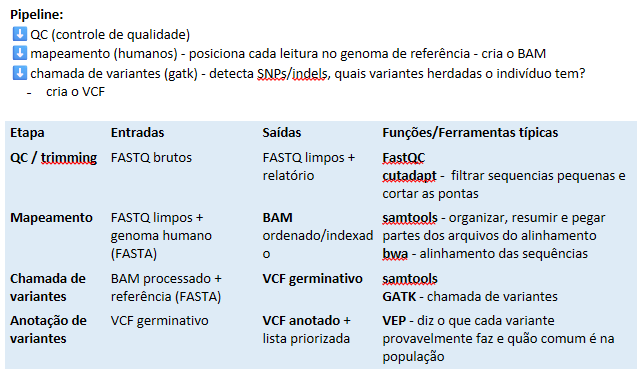

# 0. Configuração do Ambiente


In [1]:
%%bash
# Instalar miniconda e mamba (12s)
wget --quiet https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh
bash Miniforge3-Linux-x86_64.sh -b -p /usr/local -u
mamba init
mamba config set auto_activate_base true
mamba shell init --shell bash --root-prefix=~/.local/share/mamba
rm Miniforge3-Linux-x86_64.sh

PREFIX=/usr/local
Unpacking bootstrapper...
Unpacking payload...
Extracting _libgcc_mutex-0.1-conda_forge.tar.bz2
Extracting ca-certificates-2025.10.5-hbd8a1cb_0.conda
Extracting libgomp-15.2.0-h767d61c_7.conda
Extracting nlohmann_json-abi-3.12.0-h0f90c79_1.conda
Extracting pybind11-abi-4-hd8ed1ab_3.tar.bz2
Extracting python_abi-3.12-8_cp312.conda
Extracting tzdata-2025b-h78e105d_0.conda
Extracting _openmp_mutex-4.5-2_gnu.tar.bz2
Extracting libgcc-15.2.0-h767d61c_7.conda
Extracting bzip2-1.0.8-hda65f42_8.conda
Extracting c-ares-1.34.5-hb9d3cd8_0.conda
Extracting keyutils-1.6.3-hb9d3cd8_0.conda
Extracting libexpat-2.7.1-hecca717_0.conda
Extracting libffi-3.5.2-h9ec8514_0.conda
Extracting libgcc-ng-15.2.0-h69a702a_7.conda
Extracting libiconv-1.18-h3b78370_2.conda
Extracting liblzma-5.8.1-hb9d3cd8_2.conda
Extracting libnsl-2.0.1-hb9d3cd8_1.conda
Extracting libstdcxx-15.2.0-h8f9b012_7.conda
Extracting libuuid-2.41.2-he9a06e4_0.conda
Extracting libzlib-1.3.1-hb9d3cd8_2.conda
Extracting lzo-

warning  libmamba [python-3.12.12-hd63d673_1_cpython] The following files were already present in the environment:
    - bin/python
warning  libmamba [charset-normalizer-3.4.4-pyhd8ed1ab_0] The following files were already present in the environment:
    - bin/normalizer
warning  libmamba [distro-1.9.0-pyhd8ed1ab_1] The following files were already present in the environment:
    - bin/distro
warning  libmamba [jsonpointer-3.0.0-py312h7900ff3_2] The following files were already present in the environment:
    - bin/jsonpointer
warning  libmamba [wheel-0.45.1-pyhd8ed1ab_1] The following files were already present in the environment:
    - bin/wheel
warning  libmamba [jsonpatch-1.33-pyhd8ed1ab_1] The following files were already present in the environment:
    - bin/jsondiff
    - bin/jsonpatch
warning  libmamba [pip-25.2-pyh8b19718_0] The following files were already present in the environment:
    - bin/pip
    - bin/pip3
warning  libmamba [tqdm-4.67.1-pyhd8ed1ab_1] The following files

In [2]:
%%bash
# Instalar os software que vamos usar (2min)
mamba install -c bioconda -c conda-forge fastqc bwa gatk4 cutadapt samtools bedtools ensembl-vep=115 -y

Process is interrupted.


In [3]:
%%bash
# Testa se um deles foi instalado corretamente (deve printar o manual de uso do programa) (0s)
vep --help

#----------------------------------#
# ENSEMBL VARIANT EFFECT PREDICTOR #
#----------------------------------#

Versions:
  ensembl              : 115.266b84d
  ensembl-compara      : 115.ae48a7a
  ensembl-funcgen      : 115.57f7061
  ensembl-io           : 115.25061d3
  ensembl-variation    : 115.b7c2637
  ensembl-vep          : 115.2

Help: dev@ensembl.org , helpdesk@ensembl.org
Twitter: @ensembl

http://www.ensembl.org/info/docs/tools/vep/script/index.html

Usage:
./vep [--cache|--offline|--database] [arguments]

Basic options

--help                 Display this message and quit

-i | --input_file      Input file
-o | --output_file     Output file
--force_overwrite      Force overwriting of output file
--species [species]    Species to use [default: "human"]

--everything           Shortcut switch to turn on commonly used options. See web
                       documentation for details [default: off]
--fork [num_forks]     Use forking to improve script runtime

For full option doc

In [4]:
%%bash
# Criar as pastas para organizar os arquivos que serão gerados (0s)
mkdir -p raw fastqc cutadapt bwa gatk vep reference

In [5]:
%%bash
# Mover arquivos para as suas respectivas pastas e descompactar fasta.gz (0s)
mv *.fastq.gz raw/
gunzip -c Chr12-reference.fasta.gz > reference/Chr12-reference.fasta
rm -rf Chr12-reference.fasta.gz sample_data/

# 1. Controle de qualidade


In [6]:
%%bash
# Gerar o relatório da qualidade dos reads de sequenciamento (1min)
fastqc -o fastqc/ raw/caso2-sindrome-metabolica_R1.fastq.gz raw/caso2-sindrome-metabolica_R2.fastq.gz

application/gzip
application/gzip
Analysis complete for caso2-sindrome-metabolica_R1.fastq.gz
Analysis complete for caso2-sindrome-metabolica_R2.fastq.gz


Started analysis of caso2-sindrome-metabolica_R1.fastq.gz
Approx 5% complete for caso2-sindrome-metabolica_R1.fastq.gz
Approx 10% complete for caso2-sindrome-metabolica_R1.fastq.gz
Approx 15% complete for caso2-sindrome-metabolica_R1.fastq.gz
Approx 20% complete for caso2-sindrome-metabolica_R1.fastq.gz
Approx 25% complete for caso2-sindrome-metabolica_R1.fastq.gz
Approx 30% complete for caso2-sindrome-metabolica_R1.fastq.gz
Approx 35% complete for caso2-sindrome-metabolica_R1.fastq.gz
Approx 40% complete for caso2-sindrome-metabolica_R1.fastq.gz
Approx 45% complete for caso2-sindrome-metabolica_R1.fastq.gz
Approx 50% complete for caso2-sindrome-metabolica_R1.fastq.gz
Approx 55% complete for caso2-sindrome-metabolica_R1.fastq.gz
Approx 60% complete for caso2-sindrome-metabolica_R1.fastq.gz
Approx 65% complete for caso2-sindrome-metabolica_R1.fastq.gz
Approx 70% complete for caso2-sindrome-metabolica_R1.fastq.gz
Approx 75% complete for caso2-sindrome-metabolica_R1.fastq.gz
Approx 80% co

In [7]:
%%bash
# Filtrar sequências muito pequenas e cortar as pontas (1min)
cutadapt \
  -u 5 -U 5 \
  -u -5 -U -5 \
  -m 90 \
  -o cutadapt/caso2-sindrome-metabolica-trimmed_R1.fastq.gz \
  -p cutadapt/caso2-sindrome-metabolica-trimmed_R2.fastq.gz \
  raw/caso2-sindrome-metabolica_R1.fastq.gz \
  raw/caso2-sindrome-metabolica_R2.fastq.gz

This is cutadapt 5.2 with Python 3.12.3
Command line parameters: -u 5 -U 5 -u -5 -U -5 -m 90 -o cutadapt/caso2-sindrome-metabolica-trimmed_R1.fastq.gz -p cutadapt/caso2-sindrome-metabolica-trimmed_R2.fastq.gz raw/caso2-sindrome-metabolica_R1.fastq.gz raw/caso2-sindrome-metabolica_R2.fastq.gz
Processing paired-end reads on 1 core ...

=== Summary ===

Total read pairs processed:          3,000,000

== Read fate breakdown ==
Pairs that were too short:                   2 (0.0%)
Pairs written (passing filters):     2,999,998 (100.0%)

Total basepairs processed:   900,007,113 bp
  Read 1:   450,024,803 bp
  Read 2:   449,982,310 bp
Total written (filtered):    840,006,660 bp (93.3%)
  Read 1:   420,024,574 bp
  Read 2:   419,982,086 bp


# 2. Mapeamento com a referência do genoma humano

In [8]:
%%bash
# Indexar o genoma humano de referência para realizar o mapeamento e posterior remoção de contaminante (cerca de 3 min)
samtools faidx reference/Chr12-reference.fasta
bwa index reference/Chr12-reference.fasta

[bwa_index] Pack FASTA... 1.13 sec
[bwa_index] Construct BWT for the packed sequence...
[BWTIncCreate] textLength=266550618, availableWord=30755168
[BWTIncConstructFromPacked] 10 iterations done. 50732074 characters processed.
[BWTIncConstructFromPacked] 20 iterations done. 93723498 characters processed.
[BWTIncConstructFromPacked] 30 iterations done. 131930362 characters processed.
[BWTIncConstructFromPacked] 40 iterations done. 165884698 characters processed.
[BWTIncConstructFromPacked] 50 iterations done. 196059354 characters processed.
[BWTIncConstructFromPacked] 60 iterations done. 222874650 characters processed.
[BWTIncConstructFromPacked] 70 iterations done. 246704106 characters processed.
[BWTIncConstructFromPacked] 80 iterations done. 266550618 characters processed.
[bwt_gen] Finished constructing BWT in 80 iterations.
[bwa_index] 94.78 seconds elapse.
[bwa_index] Update BWT... 0.94 sec
[bwa_index] Pack forward-only FASTA... 0.70 sec
[bwa_index] Construct SA from BWT and Occ..

In [9]:
%%bash
# Proceder com o alinhamento contra o genoma humano
bwa mem reference/Chr12-reference.fasta \
  -R '@RG\tID:sample1\tSM:sample1\tPL:ILLUMINA\tLB:lib1\tPU:unit1' \
  cutadapt/caso2-sindrome-metabolica-trimmed_R1.fastq.gz \
  cutadapt/caso2-sindrome-metabolica-trimmed_R2.fastq.gz \
  | samtools sort -o bwa/sindrome-metabolica-mapped-host.bam

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 71422 sequences (10000189 bp)...
[M::process] read 71440 sequences (10000217 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 34793, 0, 0)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (319, 339, 359)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (239, 439)
[M::mem_pestat] mean and std.dev: (340.01, 28.20)
[M::mem_pestat] low and high boundaries for proper pairs: (199, 479)
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_process_seqs] Processed 71422 reads in 21.595 CPU sec, 21.375 real sec
[M::process] read 71420 sequences (10000023 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 34716, 0, 0)
[M::mem_pestat] skip orientatio

# 3. Chamada de variantes

In [10]:
%%bash
# Indexar a referência e BAM para chamada de variantes com GATK
samtools dict reference/Chr12-reference.fasta > reference/Chr12-reference.dict
samtools index bwa/sindrome-metabolica-mapped-host.bam

In [11]:
%%bash
# Chamada de variantes
gatk HaplotypeCaller \
  -R reference/Chr12-reference.fasta \
  -I bwa/sindrome-metabolica-mapped-host.bam \
  -O gatk/sindrome-metabolica-host-variants.vcf

Using GATK jar /usr/local/share/gatk4-4.6.2.0-0/gatk-package-4.6.2.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /usr/local/share/gatk4-4.6.2.0-0/gatk-package-4.6.2.0-local.jar HaplotypeCaller -R reference/Chr12-reference.fasta -I bwa/sindrome-metabolica-mapped-host.bam -O gatk/sindrome-metabolica-host-variants.vcf
12:23:00.910 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/usr/local/share/gatk4-4.6.2.0-0/gatk-package-4.6.2.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
12:23:01.234 INFO  HaplotypeCaller - ------------------------------------------------------------
12:23:01.238 INFO  HaplotypeCaller - The Genome Analysis Toolkit (GATK) v4.6.2.0
12:23:01.239 INFO  HaplotypeCaller - For support and documentation go to https://software.broadinstitute.org/gatk/
12:23:01.239 INFO  HaplotypeCaller - Executing as ro

# 4. Anotação de variantes

In [12]:
%%bash
# script oficial baixa cache do genoma humano (grande volume de dados, demora cerca de 60 min)
vep_install -a cf -s homo_sapiens -y GRCh38 --NO_UPDATE

 - getting list of available cache files
 - downloading https://ftp.ensembl.org/pub/release-115/variation/indexed_vep_cache/homo_sapiens_vep_115_GRCh38.tar.gz
 - unpacking homo_sapiens_vep_115_GRCh38.tar.gz
 - converting cache, this may take some time but will allow VEP to look up variants and frequency data much faster
 - use CTRL-C to cancel if you do not wish to convert this cache now (you may run convert_cache.pl later)
2025-10-31 12:46:41 - Processing homo_sapiens
2025-10-31 12:46:41 - Processing version 115_GRCh38
2025-10-31 12:46:41 - No unprocessed types remaining, skipping
2025-10-31 12:46:41 - All done!
 - downloading Homo_sapiens.GRCh38.dna.toplevel.fa.gz
 - downloading Homo_sapiens.GRCh38.dna.toplevel.fa.gz.fai
 - downloading Homo_sapiens.GRCh38.dna.toplevel.fa.gz.gzi

The FASTA file should be automatically detected by the VEP when using --cache or --offline.
If it is not, use "--fasta /root/.vep/homo_sapiens/115_GRCh38/Homo_sapiens.GRCh38.dna.toplevel.fa.gz"


All done


In [13]:
%%bash
# Index VCF files para anotação
bgzip gatk/sindrome-metabolica-host-variants.vcf
tabix -p vcf gatk/sindrome-metabolica-host-variants.vcf.gz

In [14]:
%%bash
# Chamar variantes usando GATK4 HaplotypeCaller
gatk --java-options "-Xmx4g" HaplotypeCaller \
  -I bwa/sindrome-metabolica-mapped-host.bam \
  -R reference/Chr12-reference.fasta \
  -O gatk/sindrome-metabolica-host-variants.vcf

Using GATK jar /usr/local/share/gatk4-4.6.2.0-0/gatk-package-4.6.2.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -Xmx4g -jar /usr/local/share/gatk4-4.6.2.0-0/gatk-package-4.6.2.0-local.jar HaplotypeCaller -I bwa/sindrome-metabolica-mapped-host.bam -R reference/Chr12-reference.fasta -O gatk/sindrome-metabolica-host-variants.vcf
12:47:47.649 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/usr/local/share/gatk4-4.6.2.0-0/gatk-package-4.6.2.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
12:47:47.968 INFO  HaplotypeCaller - ------------------------------------------------------------
12:47:47.973 INFO  HaplotypeCaller - The Genome Analysis Toolkit (GATK) v4.6.2.0
12:47:47.973 INFO  HaplotypeCaller - For support and documentation go to https://software.broadinstitute.org/gatk/
12:47:47.973 INFO  HaplotypeCaller - Executin

In [15]:
%%bash
# Indexar o arquivo BAM para a chamada de variantes
samtools index bwa/sindrome-metabolica-mapped-host.bam

In [16]:
%%bash
# Anotação de variantes a nível de proteína
vep -i gatk/sindrome-metabolica-host-variants.vcf.gz \
    --output_file vep/sindrome-metabolica-host-variants.vep.tsv \
    --tab --force_overwrite \
    --offline --cache --dir_cache ~/.vep \
    --assembly GRCh38 \
    --symbol --hgvs --canonical --af_1kg --max_af \
    --everything --pick\
    --stats_file vep/sindrome-metabolica-host-variants.vep.html